In [1]:
%matplotlib widget
import torch
import warnings
import os
import copy
import subprocess
import shlex
import matplotlib.pyplot as plt
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
from tqdm.autonotebook import tqdm
from torch.profiler import profile,  ProfilerActivity

os.environ['TORCH_CUDA_ARCH_LIST'] = f'{torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}'

from sphMath.sampling import buildDomainDescription
from sphMath.modules.adaptiveSmoothingASPH import n_h_to_nH
from sphMath.plotting import visualizeParticles, updatePlot
from sphMath.integration import getIntegrator
from sphMath.util import volumeToSupport
from sphMath.boundary import sampleDomainSDF
from sphMath.kernels import Kernel_Scale
from sphMath.sdf import getSDF, sdfFunctions, operatorDict, sampleSDF
from sphMath.regions import buildRegion, filterRegion, plotRegions
from sphMath.modules.timestep import computeTimestep
from sphMath.schemes.initializers import initializeSimulation, updateBodyParticles
from sphMath.schemes.deltaSPH import deltaPlusSPHScheme, DeltaPlusSPHSystem
from sphMath.schema import getSimulationScheme
from sphMath.enums import *
from exampleUtil import setupExampleSimulation, runSimulation, postProcess
from sphMath.sampling import sampleDivergenceFreeNoise
import math
from sphMath.sampling import sampleDivergenceFreeNoise
from sphMath.modules.particleShifting import solveShifting, shuffleParticles
import numpy as np

In [2]:
simulationName = 'Dam Break'
exportName = f'15_damBreak'

L = 2
nx = 64
dx = L / nx
targetDt = 0.0005
rho0 = 1
freeSurface = True
band = 7
fps = 50
timeLimit = 4

kernel = KernelType.Wendland4
scheme = SimulationScheme.DeltaSPH
integrationScheme = IntegrationSchemeType.symplecticEuler

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
dtype = torch.float32
targetNeighbors = n_h_to_nH(4, 2)
c_s = 0.3 * volumeToSupport(dx**2, targetNeighbors, 2) / Kernel_Scale(kernel, 2) / targetDt
exportInterval = 1 / fps
plotInterval = int(math.ceil(exportInterval / targetDt))
timesteps = int(timeLimit / targetDt)


In [3]:
dim = 2
CFL = 0.3


domain = buildDomainDescription(l = L + dx * (band) * 2, dim = dim, periodic = False, device = device, dtype = dtype)
domain.min = torch.tensor([-L, -L/2], device = device, dtype = dtype)
domain.max = torch.tensor([L, L/2], device = device, dtype = dtype)

interiorDomain = copy.deepcopy(domain)

domain.min -= dx * band
domain.max += dx * band

wrappedKernel = kernel

simulator, SimulationSystem, config, integrator = getSimulationScheme(
     scheme, kernel, integrationScheme, 
     1.0, targetNeighbors, domain)
integrationScheme = getIntegrator(integrationScheme)

config['particle'] = {
    'nx': nx + 2 * band,
    'dx': L/nx,
    'targetNeighbors': targetNeighbors,
    'band': band
}
config['fluid'] = {
    'rho0': rho0,
    'c_s': c_s
}
config['surfaceDetection']['active'] = freeSurface
config['shifting']['freeSurface'] = freeSurface
config['pressure']['term'] = 'Antuono'

config['gravity'] = {
    'active': True,
    'magnitude': 10,
    'mode': 'directional',
    'direction': torch.tensor([0, -1], device = device, dtype = dtype)
}
# config['EOS'] = {'type': 'stiffTait'}
#config['shifting']['projectionScheme'] = 'dot'

In [4]:
fluid_sdf = lambda x: sampleDomainSDF(x, domain, invert = True)
domain_sdf = lambda x: sampleDomainSDF(x, interiorDomain, invert = False)
obstacle_sdf = lambda points: sampleSDF(points, lambda x: getSDF('hexagon')['function'](x, torch.tensor(1/4).to(points.device)), invert = False)


W = L*5/6
H = L/3
box_sdf = lambda points: sampleSDF(points, operatorDict['translate'](lambda x: getSDF('box')['function'](x, torch.tensor([W/2,H/2]).to(points.device)), torch.tensor([interiorDomain.min[0]+W/2,interiorDomain.min[1] + H/2]).to(points.device)), invert = False)
config['particle']['shortEdge'] = True

# inlet_sdf = lambda points: sampleSDF(points, operatorDict['translate'](lambda x: getSDF('box')['function'](x, torch.tensor([L/16,L/2]).to(points.device)), torch.tensor([domain.min[0]+L/16,0]).to(points.device)), invert = False)
# outlet_sdf = lambda points: sampleSDF(points, operatorDict['translate'](lambda x: getSDF('box')['function'](x, torch.tensor([L/12,L]).to(points.device)), torch.tensor([domain.max[0]-L/12,0]).to(points.device)), invert = False)
# outletBuffer_sdf = lambda points: sampleSDF(points, operatorDict['translate'](lambda x: getSDF('box')['function'](x, torch.tensor([L/8,L]).to(points.device)), torch.tensor([domain.max[0]-L/8,0]).to(points.device)), invert = False)


regions = []

regions.append(buildRegion(sdf = domain_sdf, config = config, type = 'boundary', kind = 'constant'))
# regions.append(buildRegion(sdf = obstacle_sdf, config = config, type = 'boundary', kind = 'constant'))
regions.append(buildRegion(sdf = box_sdf, config = config, type = 'fluid'))
# regions.append(buildRegion(sdf = fluid_sdf, config = config, type = 'forcing', dirichletValues={'velocities': forcing}))

# regions.append(buildRegion(sdf = inlet_sdf, config = config, type = 'inlet', dirichletValues={'densities': config['fluid']['rho0'], 'velocities': torch.tensor([1,0], device = device, dtype = dtype)}, updateValues = {'densities': 0, 'velocities': torch.tensor([0,0], device = device, dtype = dtype)}))

# regions.append(buildRegion(sdf = outlet_sdf, config = config, type = 'outlet'))
# regions.append(buildRegion(sdf = outletBuffer_sdf, config = config, type = 'buffer', bufferValues = ['densities', 'velocities', 'pressures']))

# regions.append(buildRegion(sdf = box_sdf, config = config, type = 'dirichlet', dirichletValues={'densities': 2.0, 'velocities': torch.tensor([1,2], device = device, dtype = dtype), 'pressures': lambda x: torch.where(x[:,0] > 0, 0.0, 1.0)}, updateValues = {'densities': 2.0}))


for region in regions:
    region = filterRegion(region, regions)



3941


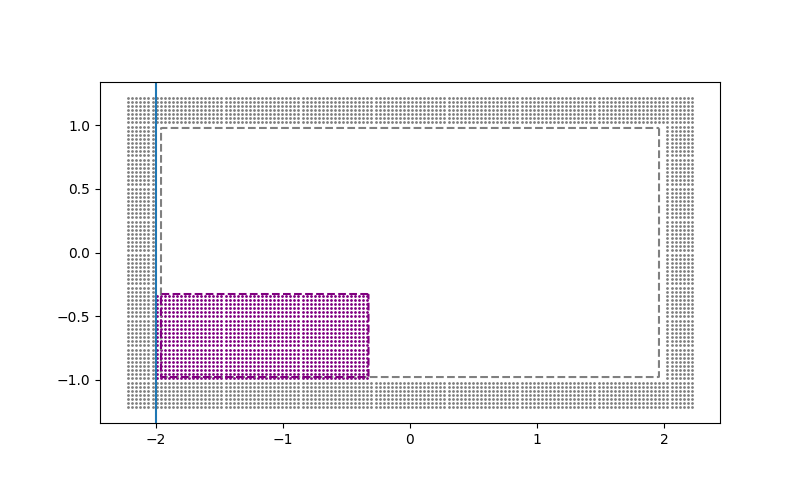

In [5]:

fig, axis = plt.subplots(1, 1, figsize=(8, 5), squeeze=False)
    
plotRegions(regions, axis[0,0], plotFluid = True, plotParticles = True)
axis[0,0].axvline(-2)

axis[0,0].set_aspect('equal')

print(sum([region['particles'].positions.shape[0] for region in regions]))

In [6]:
particleState, config, rigidBodies = initializeSimulation(scheme, config, regions)


In [7]:
config['shifting']['active'] = True

In [8]:
figsize = (12, 4)
markerSize = 1
stacked = 'horizontal'
dt = computeTimestep(scheme, 1e-2, particleState, config, None)
particles = copy.deepcopy(particleState)
particleSystem = DeltaPlusSPHSystem(config['domain'], None, 0., copy.deepcopy(particleState), 'momentum', None, rigidBodies = config['rigidBodies'], regions = config['regions'], config = config)

for rigidBody in config['rigidBodies']:
    particleState = updateBodyParticles(scheme, particleState, rigidBody)


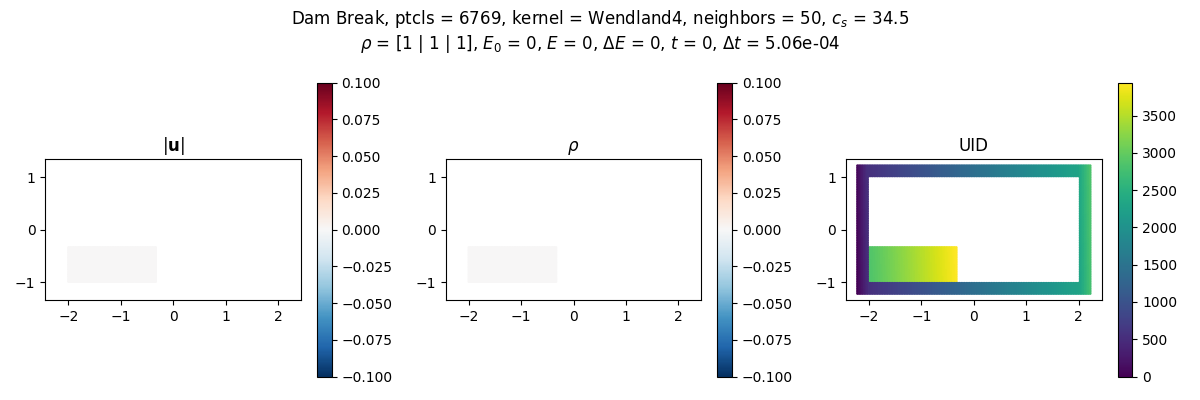

In [9]:

## Setup values for plotting 

kineticEnergy = 0.5 * particleState.densities * (particleState.velocities ** 2).sum(1)

t = 0
E_k0 = 0.5 * particleState.masses * torch.linalg.norm(particleState.velocities, dim = -1)**2
E_k = 0.5 * particleState.masses * torch.linalg.norm(particleState.velocities, dim = -1)**2

rhoMin = particleState.densities.min().detach().cpu().item() / config['fluid']['rho0']
rhoMean = particleState.densities.mean().detach().cpu().item() / config['fluid']['rho0']
rhoMax = particleState.densities.max().detach().cpu().item() / config['fluid']['rho0']

initialVelocity = particleState.velocities.clone()
initialDensities = particleState.densities.clone()
initialPotentialEnergy = None

if config['gravity']['active']:
    if 'mode' in config['gravity'] and config['gravity']['mode'] == 'potential':
        B = config['gravity']['magnitude']
        initialPotentialEnergy = 0.5 * B**2 * particleState.masses / config['fluid']['rho0'] * particleState.densities * torch.linalg.norm(particleState.positions, dim = -1)**2

initialKineticEnergy = 0.5 * particleState.masses / config['fluid']['rho0'] * particleState.densities * torch.linalg.norm(initialVelocity, dim = -1)**2
initialEnergy = initialKineticEnergy + initialPotentialEnergy if initialPotentialEnergy is not None else initialKineticEnergy

if stacked == 'horizontal':
    fig, axis = plt.subplots(1, 3, figsize = figsize, squeeze=False)
elif stacked == 'vertical':
    fig, axis = plt.subplots(3, 1, figsize = figsize, squeeze=False)
else:
    raise ValueError(f"Invalid value for 'stacked': {stacked}. Expected 'horizontal' or 'vertical'.")

axes = axis.flatten()

# markerSize = 1
velocityPlot = visualizeParticles(fig, axes[0], 
            particles = particleSystem.systemState, 
            domain = config['domain'], 
            quantity = particleSystem.systemState.velocities, 
            which = 'fluid',
            mapping = '.x',
            cmap = 'RdBu_r',
            visualizeBoth=False,
            kernel = config['kernel'],
            plotDomain = False,
            gridVisualization=False, markerSize=markerSize, streamLines=False)

densityPlot = visualizeParticles(fig, axes[1],
            particles = particleSystem.systemState, 
            domain = config['domain'], 
            quantity = particleSystem.systemState.velocities, 
            which = 'fluid',
            # operation = 'curl',
            mapping = '.y',
            cmap = 'RdBu_r',
            visualizeBoth=False,
            kernel = config['kernel'],
            plotDomain = False,
            gridVisualization=False, markerSize=markerSize)

uidPlot = visualizeParticles(fig, axes[2],
            particles = particleSystem.systemState, 
            domain = config['domain'], 
            quantity = particleSystem.systemState.UIDs, 
            which = 'both',
            mapping = '.x',
            cmap = 'viridis',
            visualizeBoth=False,
            kernel = config['kernel'],
            plotDomain = False,
            gridVisualization=False, markerSize=markerSize, streamLines=False)
axis[0,0].set_title(r'$|\mathbf{u}|$')
axis[0,1].set_title(r'$\rho$')
axis[0,2].set_title(r'UID')

totalInitialEnergy = (initialEnergy).sum().detach().cpu().item()
totalEnergy = (initialEnergy).sum().detach().cpu().item()

fig.suptitle(f'{simulationName}, ptcls = {particleState.positions.shape[0]}, kernel = {config["kernel"].name}, neighbors = {config["targetNeighbors"]:.2g}, $c_s$ = {config["fluid"]["c_s"]:.1f}\n$\\rho$ = [{rhoMin:.4g} | {rhoMean:.4g} | {rhoMax:.4g}], $E_0$ = {totalInitialEnergy:.4g}, $E$ = {totalEnergy:.4g}, $\\Delta E$ = {totalEnergy - totalInitialEnergy:.4g}, $t$ = {particleSystem.t:.4g}, $\Delta t$ = {dt:.2e}')

fig.tight_layout()


In [10]:
## Setup simulation, everything after this should be the same for all examples
# fig, axis, velocityPlot, densityPlot, uidPlot, particleSystem, dt, initialKineticEnergy, initialPotentialEnergy, initialEnergy = setupExampleSimulation(simulationName, scheme, particleState, config, regions, stacked = 'horizontal', figsize = (12, 4))

imagePrefix = f'./images/{exportName}/'
os.makedirs(imagePrefix, exist_ok = True)
fig.savefig(f'{imagePrefix}frame_{0:05d}.png', dpi = 100)


In [11]:
for i in (tq:=tqdm(range(timesteps))):
    particleSystem, currentState, updates = integrationScheme.function(particleSystem, dt, simulator, config, priorStep = particleSystem.priorStep, verbose = False)
    
    # if callBackFn is not None:
        # particleSystem = callBackFn(particleSystem)
    
    if i % plotInterval == plotInterval - 1 or i == timesteps - 1:

        rhoMin = particleSystem.systemState.densities.min().detach().cpu().item() / config['fluid']['rho0']
        rhoMean = particleSystem.systemState.densities.mean().detach().cpu().item() / config['fluid']['rho0']
        rhoMax = particleSystem.systemState.densities.max().detach().cpu().item() / config['fluid']['rho0']

        kineticEnergy = 0.5 * particleSystem.systemState.masses / config['fluid']['rho0'] * particleSystem.systemState.densities * torch.linalg.norm(particleSystem.systemState.velocities, dim = -1)**2
        potentialEnergy = None
        if config['gravity']['active']:
            if 'mode' in config['gravity'] and config['gravity']['mode'] == 'potential':
                B = config['gravity']['magnitude']
                potentialEnergy = 0.5 * B**2 * particleSystem.systemState.masses / config['fluid']['rho0'] * particleSystem.systemState.densities * torch.linalg.norm(particleSystem.systemState.positions, dim = -1)**2
                
        combinedEnergy = kineticEnergy + potentialEnergy if potentialEnergy is not None else kineticEnergy
        totalInitialEnergy = (initialEnergy).sum().detach().cpu().item()
        totalEnergy = (combinedEnergy).sum().detach().cpu().item()

        fig.suptitle(f'{simulationName}, ptcls = {particleSystem.systemState.positions.shape[0]}, kernel = {config["kernel"].name}, neighbors = {config["targetNeighbors"]:.2g}, $c_s$ = {config["fluid"]["c_s"]:.1f}\n$\\rho$ = [{rhoMin:.4g} | {rhoMean:.4g} | {rhoMax:.4g}], $E_0$ = {totalInitialEnergy:.4g}, $E$ = {totalEnergy:.4g}, $\\Delta E$ = {totalEnergy - totalInitialEnergy:.4g}, $t$ = {particleSystem.t:.4g}, $\Delta t$ = {dt:.2e}')
        updatePlot(velocityPlot, particleSystem.systemState, particleSystem.systemState.surfaceNormals)
        updatePlot(densityPlot, particleSystem.systemState, particleSystem.systemState.surfaceNormals)
        updatePlot(uidPlot, particleSystem.systemState, particleSystem.systemState.densities)
        # if plotCallbackFn is not None:
            # plotCallbackFn(fig, axis, particleSystem, i)
        fig.canvas.draw()
        fig.canvas.flush_events()
        fig.savefig(f'{imagePrefix}frame_{i:05d}.png', dpi = 100)


  0%|          | 0/8000 [00:00<?, ?it/s]

Namespace EOS not found in config. Setting type to isoThermal
Key kappa not found in config["EOS"]. Setting kappa to 1.3
Key polytropicExponent not found in config["EOS"]. Setting polytropicExponent to 7
Key gas_constant not found in config["EOS"]. Setting gas_constant to 8.314
Key molarMass not found in config["EOS"]. Setting molarMass to 0.02897
Key surfaceDetection not found in config["surfaceDetection"]. Setting surfaceDetection to Barecasco
Key normalScheme not found in config["surfaceDetection"]. Setting normalScheme to Lambda
Key colorSurfaceThreshold not found in config["surfaceDetection"]. Setting colorSurfaceThreshold to 1.5
Key colorGradientSurfaceThreshold not found in config["surfaceDetection"]. Setting colorGradientSurfaceThreshold to 10.0
Key barecascoThreshold not found in config["surfaceDetection"]. Setting barecascoThreshold to 1.0471975511965976
Key expansionIters not found in config["surfaceDetection"]. Setting expansionIters to 1
Key delta not found in config["diff

In [ ]:

runSimulation(simulationName, particleSystem, integrationScheme, simulator, timesteps, dt, config, fig, axis, velocityPlot, densityPlot, uidPlot, initialEnergy, imagePrefix, plotInterval)

print('Finished simulation')
## Post process simulation
postProcess(imagePrefix, fps, timesteps, exportName)
## Cleanup

In [ ]:
fig, axis = plt.subplots(1, 1, figsize=(8, 5), squeeze=False)
axis[0,0].scatter(particleState.positions[:,0].cpu(), particleState.positions[:,1].cpu(), s = 1)

In [ ]:
/